In [1]:
%matplotlib notebook
import numpy as np
import pandas as pd
import math
import itertools
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyEDM import *

## Creating a model with noise

<IPython.core.display.Javascript object>


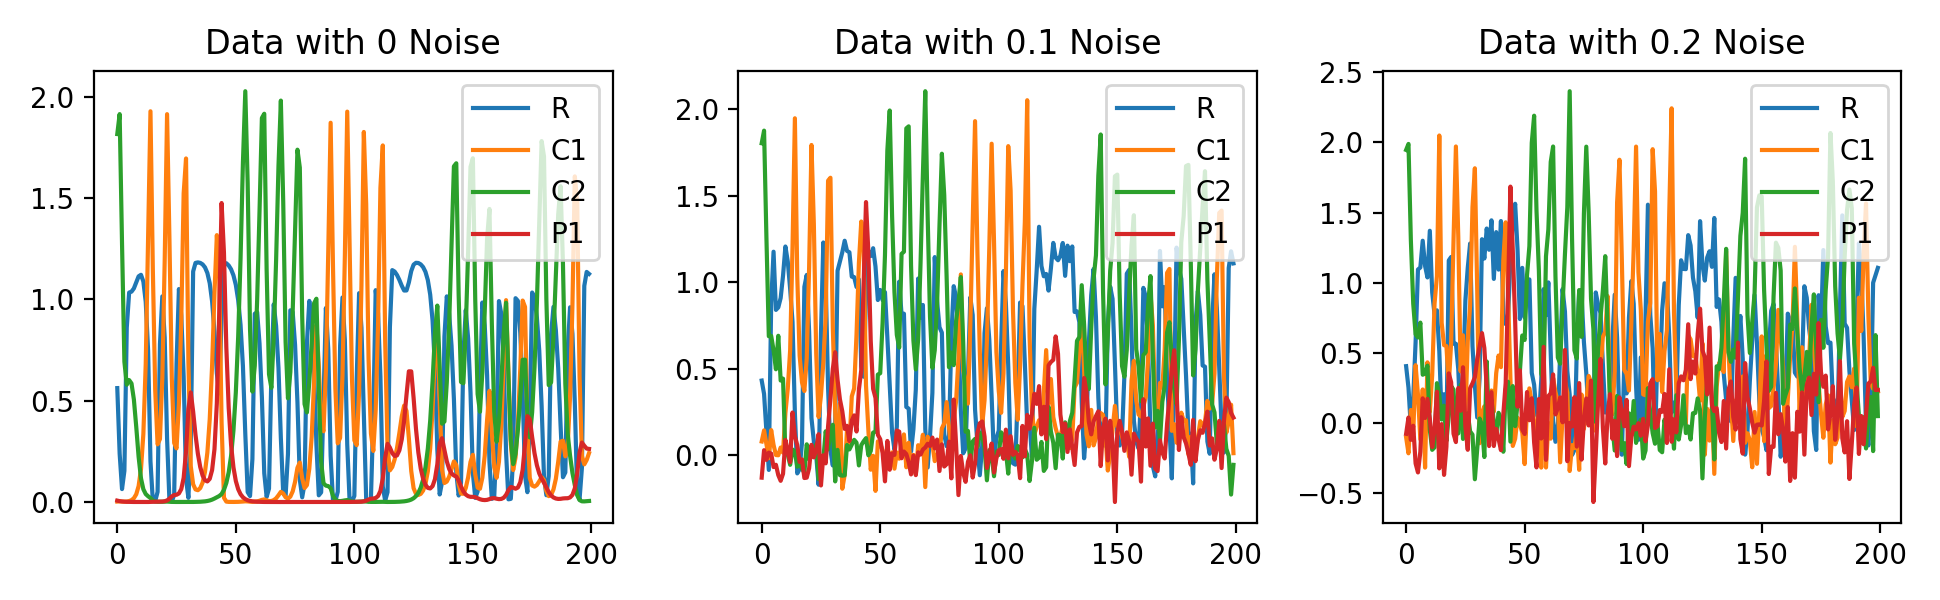

In [2]:
data = pd.read_csv('~/Desktop/species_models/5_Species_Model_Output.csv')
data = data.iloc[:200,:]

d={}
for std in arange(0,0.35,0.05):
    noise_level = round(std, 2)
    noise = np.random.normal(0.0, noise_level, size = (data.shape[0], data.shape[1]-1))
    noise = pd.DataFrame(noise)
    noise = pd.concat([pd.DataFrame(np.zeros(shape = (data.shape[0], 1))), noise], axis=1)
    noise.columns = data.columns
    noisy_data = noise + data
    noisy_data.iloc[:,0] = noisy_data.iloc[:,0].astype(int)
    d["noisy_data_{0}".format(noise_level)] = noisy_data
    
noisy_data_1 = d["noisy_data_0.05"]
noisy_data_2 = d["noisy_data_0.1"]
noisy_data_3 = d["noisy_data_0.15"]
noisy_data_4 = d["noisy_data_0.2"]
noisy_data_5 = d["noisy_data_0.25"]
noisy_data_6 = d["noisy_data_0.3"]

fig = plt.figure(figsize=(9.7,3.0))
axes1 = fig.add_subplot(131);          axes2 = fig.add_subplot(132);           axes3 = fig.add_subplot(133)
axes1.plot(data.iloc[:,1:5]);          axes2.plot(noisy_data_2.iloc[:,1:5]);   axes3.plot(noisy_data_4.iloc[:,1:5])
axes1.set_title('Data with 0 Noise');  axes2.set_title('Data with 0.1 Noise'); axes3.set_title('Data with 0.2 Noise')
axes1.legend(['R', 'C1', 'C2', 'P1']); axes2.legend(['R', 'C1', 'C2', 'P1']);  axes3.legend(['R', 'C1', 'C2', 'P1'])

fig.tight_layout()
plt.show()

## Defining the functions

In [3]:
def valid_combinations(data, E, tau, lib, causal_col, affected_cols):
    '''Get a list of all the valid combinations of variables and lags that can be used for multivatiate embeddings.
    Valid = not containing (t-0) lags of the target column'''
    
    # Get list of all columns
    col_list = list([causal_col[0]])
    for idx in range(0,len(affected_cols), 1): 
        col_list = col_list + list([affected_cols[idx]])
        
    # Get a list of all possible combinations of variables and lags.
    lags = Embed(dataFrame=data, E=E, tau=tau, columns=col_list).columns 
    combinations = list(itertools.combinations(lags, E))
    
    # Store valid combinations in list valid_combinations.
    valid_combos = list()
    for combination in combinations:
        if causal_col[0]+'(t-0)' not in combination:
            valid_combos = valid_combos + list([combination])
            
    return valid_combos

In [4]:
def best_k_reconstructions(data, E, tau, causal_col, affected_cols, valid_combinations, print_best_k = True):
    '''Return the best k embeddings (best = best rho for cross map to the causal variable) and their rho value'''
    m = len(valid_combinations)
    k = round(math.sqrt(m))                         # Arbitrary: k = √m, where m is the number of valid embeddings
    
    # Get list of all columns
    col_list = list([causal_col[0]])
    for idx in range(0,len(affected_cols), 1): col_list = col_list + list([affected_cols[idx]])
    
    # A dataframe with every possible variable and its lags
    lags = Embed(dataFrame = data, E=E, tau=tau, columns=col_list)
    
    # For each embedding, create a cross-map reconstruction of the causal variable and calculate rho between the 
    # reconstructed values and the actual values. Record in dataframe all_reconstructions.
    # Save all cross mapps in a dictionary called cross_maps. Access them like: cross_maps['19'], where 19 is the
    # index of that combination in valid_combinations.
    all_reconstructions = pd.DataFrame([valid_combinations]).T
    rhos = pd.DataFrame()
    cross_maps = {}
    
    idx_count = 0
    for combination in valid_combinations:
        # Get a DataFrame with the embedding listed in combination, plus the causal column.
        # Use the Simplex function with Tp = 0, target = casual column to get a cross-map prediction.
        df = lags.loc[:,list(combination)+list([causal_col[0]+'(t-0)'])]
        df = pd.concat([pd.DataFrame([range(1,len(df)+1,1)]).T, df], axis=1)
        df = df.rename(columns={0: 'time step'})

        cross_map = Simplex(dataFrame = df, lib=lib, pred=pred, Tp=0, columns=list(df.columns[1:-1]),
                            target=df.columns[-1], exclusionRadius=E, embedded=True)
        
        cross_maps["{0}".format(all_reconstructions.index[idx_count])] = cross_map
        
        rho = cross_map.loc[:,['Observations','Predictions']].corr().iloc[0,1]
        rhos = pd.concat([rhos, pd.DataFrame([rho])])
        idx_count += 1
    
    rhos = rhos.reset_index(drop=True)
    all_reconstructions = pd.concat([all_reconstructions, rhos], axis=1)
    all_reconstructions.columns = ['embedding', 'cross-map rho']  
    
    # Determine the best k reconstructions.
    all_reconstructions    = all_reconstructions.sort_values(by = 'cross-map rho', axis = 0, ascending = False)
    best_k_reconstructions = all_reconstructions.iloc[:k,:]
    
    if print_best_k == True:
        print('Best k reconstructions are: ')
        display(best_k_reconstructions)

    ##### Demonstration of using the dictionary cross_maps to access the individual cross maps and rho values #####
    #print('the third reconstruction is:'); print(cross_maps['3'])
    #print('rho of the 3rd reconstruction is', cross_maps['3'].loc[:,['Observations','Predictions']].corr().iloc[0,1])

    return cross_maps, k, best_k_reconstructions

In [5]:
def avg_of_best_k_reconstructions(cross_maps, k, best_k_reconstructions):
    '''Get one reconstruction that is the average of the best k reconstructions from the previous steps.'''
    
    # DataFrame of zeros to store the sum of the best k reconstructions in
#    sum_of_best_k_reconstructions = pd.DataFrame(np.zeros(shape=(cross_maps['0'].shape[0],1)))
#    sum_of_best_k_reconstructions.columns = ['Predictions']
    
    # If there is a missing value, fill it with the value of the averaged best reconstruction so far
#    count = 0
#    for idx in best_k_reconstructions.index:
#        sum_of_best_k_reconstructions = sum_of_best_k_reconstructions.add(pd.DataFrame([cross_maps[str(idx)].loc[:,'Predictions']]).T,
#                                        fill_value = sum_of_best_k_reconstructions.loc[idx]/count)
#        count +=1

#    avg_of_best_k_reconstructions = sum_of_best_k_reconstructions.divide(k)
#    avg_of_best_k_reconstructions = pd.concat([cross_maps['0'].loc[:,['time step', 'Observations']], 
#                                               avg_of_best_k_reconstructions], axis=1)
    
#    pred_variance = pd.DataFrame([avg_of_best_k_reconstructions.loc[:,['Observations', 'Predictions']].var(axis=1)]).T
#    avg_of_best_k_reconstructions = pd.concat([avg_of_best_k_reconstructions, pred_variance], axis=1)
#    avg_of_best_k_reconstructions.columns = ['time step', causal_col[0], 'Reconstruction', 'Variance']
    
    all_k_reconstructions = pd.DataFrame()
    
    for idx in best_k_reconstructions.index:
        all_k_reconstructions = pd.concat([all_k_reconstructions,
                                           pd.DataFrame([cross_maps[str(idx)].loc[:,'Predictions']]).T], axis=1)
        
    avg_of_best_k_reconstructions = pd.DataFrame(all_k_reconstructions.mean(axis=1))
    avg_of_best_k_reconstructions.columns = ['Predictions']
    avg_of_best_k_reconstructions = pd.concat([cross_maps['0'].loc[:,['time step', 'Observations']], 
                                               avg_of_best_k_reconstructions], axis=1)
    
    pred_variance = pd.DataFrame([avg_of_best_k_reconstructions.loc[:,['Observations', 'Predictions']].var(axis=1)]).T
    avg_of_best_k_reconstructions = pd.concat([avg_of_best_k_reconstructions, pred_variance], axis=1)
    avg_of_best_k_reconstructions.columns = ['time step', causal_col[0], 'Reconstruction', 'Variance']

    return avg_of_best_k_reconstructions

In [6]:
def plot_results(data, noisy_data, noise_level, reconstruction, causal_col):
    '''Plots the reconstructed vs. the actual data; and the noise level before and after the method was applied.'''
    # Reconstructed vs. Actual Data
    
    fig = plt.figure(figsize=(9.7,3))
    axes1 = fig.add_subplot(121); axes2 = fig.add_subplot(122)
    
    rho = reconstruction.loc[:,[causal_col[0],'Reconstruction']].corr().iloc[0,1]
    
    axes1.title.set_text('Average of Best k Reconstructions'+'\n'+
                         'rho='+str(rho))
    axes2.title.set_text('Reconstructed vs. Actual Data')
    
    reconstruction.plot(ax=axes1)
    axes2.scatter(reconstruction.loc[:,[causal_col[0]]], reconstruction.loc[:,['Reconstruction']])
    axes2.plot(axes2.get_ylim(), axes2.get_ylim())
    
    fig.tight_layout()
    plt.show()
    
    # Noise levels before and after
    fig = plt.figure(figsize = (9.7,3))
    axes1 = fig.add_subplot(121); axes2 = fig.add_subplot(122)
    title =              'Noise: Level ' + noise_level
    axes1.title.set_text(title)
    axes2.title.set_text('Noise after Noise Reduction')

    axes1.plot(noisy_data.loc[reconstruction.index,[causal_col[0]]] - data.loc[reconstruction.index,[causal_col[0]]])
    axes2.plot(reconstruction.loc[:,['Reconstruction']].values - reconstruction.loc[:,[causal_col[0]]].values)

    fig.tight_layout()
    plt.show()
    return rho

In [7]:
def reconstruct(data, noisy_data, E, tau, lib, pred, causal_col, affected_cols):
    valid_combos          = valid_combinations(data, E, tau, lib, causal_col, affected_cols)
    cross_maps, k, best_k = best_k_reconstructions(noisy_data, E, tau, causal_col, affected_cols, valid_combos)
    reconstruction        = avg_of_best_k_reconstructions(cross_maps, k, best_k)
    rho                   = plot_results(data, noisy_data, noise_level, reconstruction, causal_col)
    return cross_maps, rho

In [8]:
def reconstruct_no_plot(data, noisy_data, E, tau, lib, pred, causal_col, affected_cols):
    valid_combos          = valid_combinations(data, E, tau, lib, causal_col, affected_cols)
    cross_maps, k, best_k = best_k_reconstructions(noisy_data, E, tau, causal_col, affected_cols, valid_combos,
                                                  print_best_k = False)
    reconstruction        = avg_of_best_k_reconstructions(cross_maps, k, best_k)
    rho                   = reconstruction.loc[:,[causal_col[0],'Reconstruction']].corr().iloc[0,1]
    return cross_maps, rho

## Running the code - does it reduce noise?

In [32]:
data = pd.read_csv('~/Desktop/species_models/5_Species_Model_Output.csv')
data = data.iloc[:200,:]
noisy_data    = data
noise_level   = '0.0'
E             = 3
tau           = -1
lib           = "1 100"
pred          = "101 200"
causal_col    = ['C2']
affected_cols = ['P1', 'R', 'C1']

#cross_maps, rho = reconstruct(data, noisy_data, E, tau, lib, pred, causal_col, affected_cols)
#rho

In [36]:
# Testing simplex vs. cross map reconstruction for different noise levels

simplex = Simplex(dataFrame = data, E=E, lib=lib, pred=pred, Tp=0, columns = causal_col[0], target = causal_col[0],
                  exclusionRadius = E, embedded=False)
simplex_rho = simplex.loc[:,['Observations', 'Predictions']].corr().iloc[0,1]
print(simplex_rho)
print(rho)

0.9968388542592496
0.9869659050937476


## Comparing noise to simplex

<IPython.core.display.Javascript object>


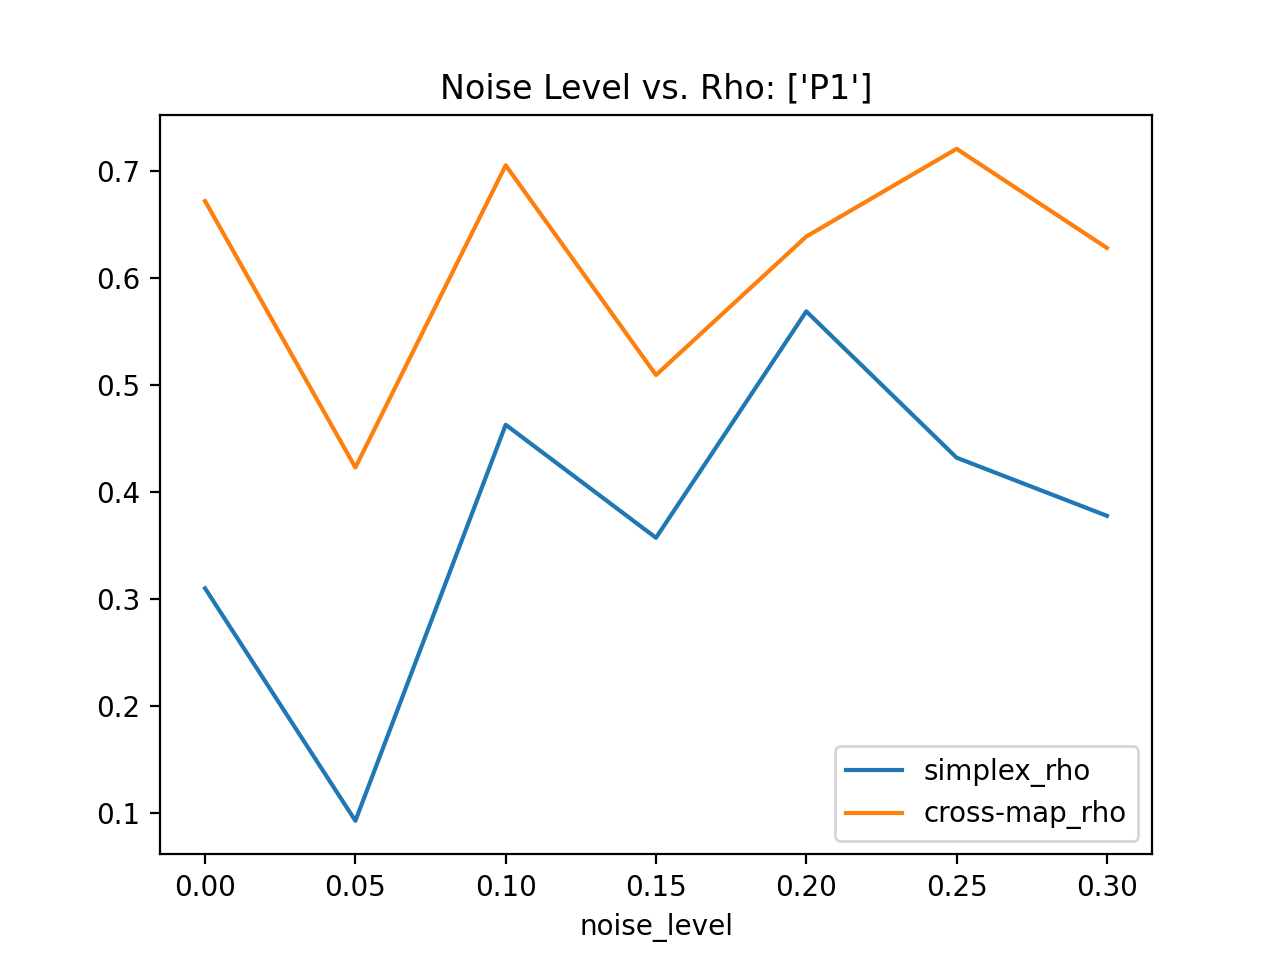

<AxesSubplot:title={'center':"Noise Level vs. Rho: ['P1']"}, xlabel='noise_level'>

In [53]:
data = pd.read_csv('~/Desktop/species_models/5_Species_Model_Output.csv')
data = data.iloc[:50,:]
noisy_data    = data
noise_level   = '0.0'
E             = 3
tau           = -1
lib           = "1 25"
pred          = "26 50"
causal_col    = ['P1']
affected_cols = ['R', 'C2', 'C1']

noise_vs_rho  = pd.DataFrame([arange(0,0.35,0.05)]).T
noise_vs_rho.columns = ['noise_level']

simplex_rhos = pd.DataFrame()
crossmap_rhos = pd.DataFrame()

actual_data = data.loc[int(pred.split(' ', 1)[0])-1:int(pred.split(' ', 1)[1]),[causal_col[0]]]
actual_data = actual_data.reset_index(drop=True)

for noisy_data in d:
    noisy_data = d[noisy_data]
    
    # Get cross-map reconstruction and its rho value
    valid_combos = valid_combinations(data, E, tau, lib, causal_col, affected_cols)
    cross_maps, k, best_k = best_k_reconstructions(noisy_data, E, tau, causal_col, affected_cols, valid_combos,
                                                  print_best_k = False)
    reconstruction = avg_of_best_k_reconstructions(cross_maps, k, best_k)
    
    crossmap_reconstruction = reconstruction.loc[:,['Reconstruction']]
    crossmap_reconstruction = pd.concat([actual_data, crossmap_reconstruction], axis=1)
    
    crossmap_rho = crossmap_reconstruction.loc[:,[causal_col[0], 'Reconstruction']].corr().iloc[0,1]
    
    # Get simplex reconstruction and its rho value
    simplex = Simplex(dataFrame = noisy_data, E=E, lib=lib, pred=pred, Tp=0, columns = causal_col[0], target = causal_col[0],
                      exclusionRadius = E, embedded=False)
    
    simplex_reconstruction = pd.concat([actual_data, simplex.loc[:,['Predictions']]], axis=1)
    simplex_rho = simplex_reconstruction.loc[:,[causal_col[0], 'Predictions']].corr().iloc[0,1]
    
    
    crossmap_rhos = pd.concat([crossmap_rhos, pd.DataFrame([crossmap_rho])])
    simplex_rhos = pd.concat([simplex_rhos, pd.DataFrame([simplex_rho])])

crossmap_rhos.columns = ['cross-map_rho']
simplex_rhos.columns = ['simplex_rho']
crossmap_rhos = crossmap_rhos.reset_index(drop=True)
simplex_rhos = simplex_rhos.reset_index(drop=True)

noise_vs_rho = pd.concat([noise_vs_rho, simplex_rhos, crossmap_rhos], axis=1)

title = 'Noise Level vs. Rho: ' + str([causal_col[0]])
noise_vs_rho.plot(title=title, x='noise_level')

In [112]:
data

,Unnamed: 0,R,C1,C2,P1
0,1,0.562018,0.002226,1.815200,0.006884
1,2,0.238250,0.002987,1.913687,0.004210
2,3,0.063778,0.002384,1.275531,0.002576
3,4,0.153577,0.001665,0.692132,0.001572
4,5,0.860214,0.002310,0.578684,0.000959
...,...,...,...,...,...
195,196,0.012392,0.622369,0.009397,0.244702
196,197,0.169312,0.226556,0.003472,0.293259
197,198,1.066307,0.185847,0.003148,0.277443
198,199,1.135067,0.207160,0.003872,0.263697
